# 1.1 Analisis Exploratorio de datos

Cargamos los datos inicialmente

In [48]:
import pandas as pd

data_path = 'data/home_data.csv'
df = pd.read_csv(data_path)

# vemos el esquema del Dataframe para darnos una idea inicial de las columnas y tipos de datos
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Podemos ver que tenemos un dataframe con 21613 registros, 21 columnas, y que no hay valores nulos en cada columna inicialmente

Para el EDA, Personalmente me gusta usar una libreria llamada ydata_profiling, allí puedo evaluar de manera integra la estructura de los datos en un .html que se genera

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="data_precio_viviendas ")
profile.to_file("data_precio_viviendas.html")


Podemos ver el resumen estadistico del df, el tipo de variables y la cantidad de memoria que ocupa el dataset

![overview](img/overview.png)

además podemos ver un resumen por cada columna para identificar aspectos importantes:

columna id

![id](img/resumenId.png)

columna Price

![price](img/resumenPrice.png)

columna bathrooms

![bathroom](img/resumenBathrooms.png)

columna Bedrooms

![bedrooms](img/resumenBedrooms.png)

columna floors

![floors](img/resumenFloors.png)

columna sqft_above

![sqft_above](img/resumensqft_above.png)

columna sqft_basement

![sqft_basement](img/resumensqft_basement.png)

columna sqft_living

![sqft_living](img/resumensqft_living.png)

columna sqtf_lot

![sqft_lot](img/resumensqft_lot.png)

![correlaciones](img/resumenCorrelaciones.png)



In [49]:
# exploremos las correlaciones solo del precio con las demás variables numéricas
numeric_df = df.select_dtypes(include=['number'])

# Calcular correlaciones con 'price'
correlations = numeric_df.corr()['price'].sort_values(ascending=False)

print("\n🔗 Top 10 Correlaciones con el Precio:")
print(correlations.head(11))


🔗 Top 10 Correlaciones con el Precio:
price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
Name: price, dtype: float64


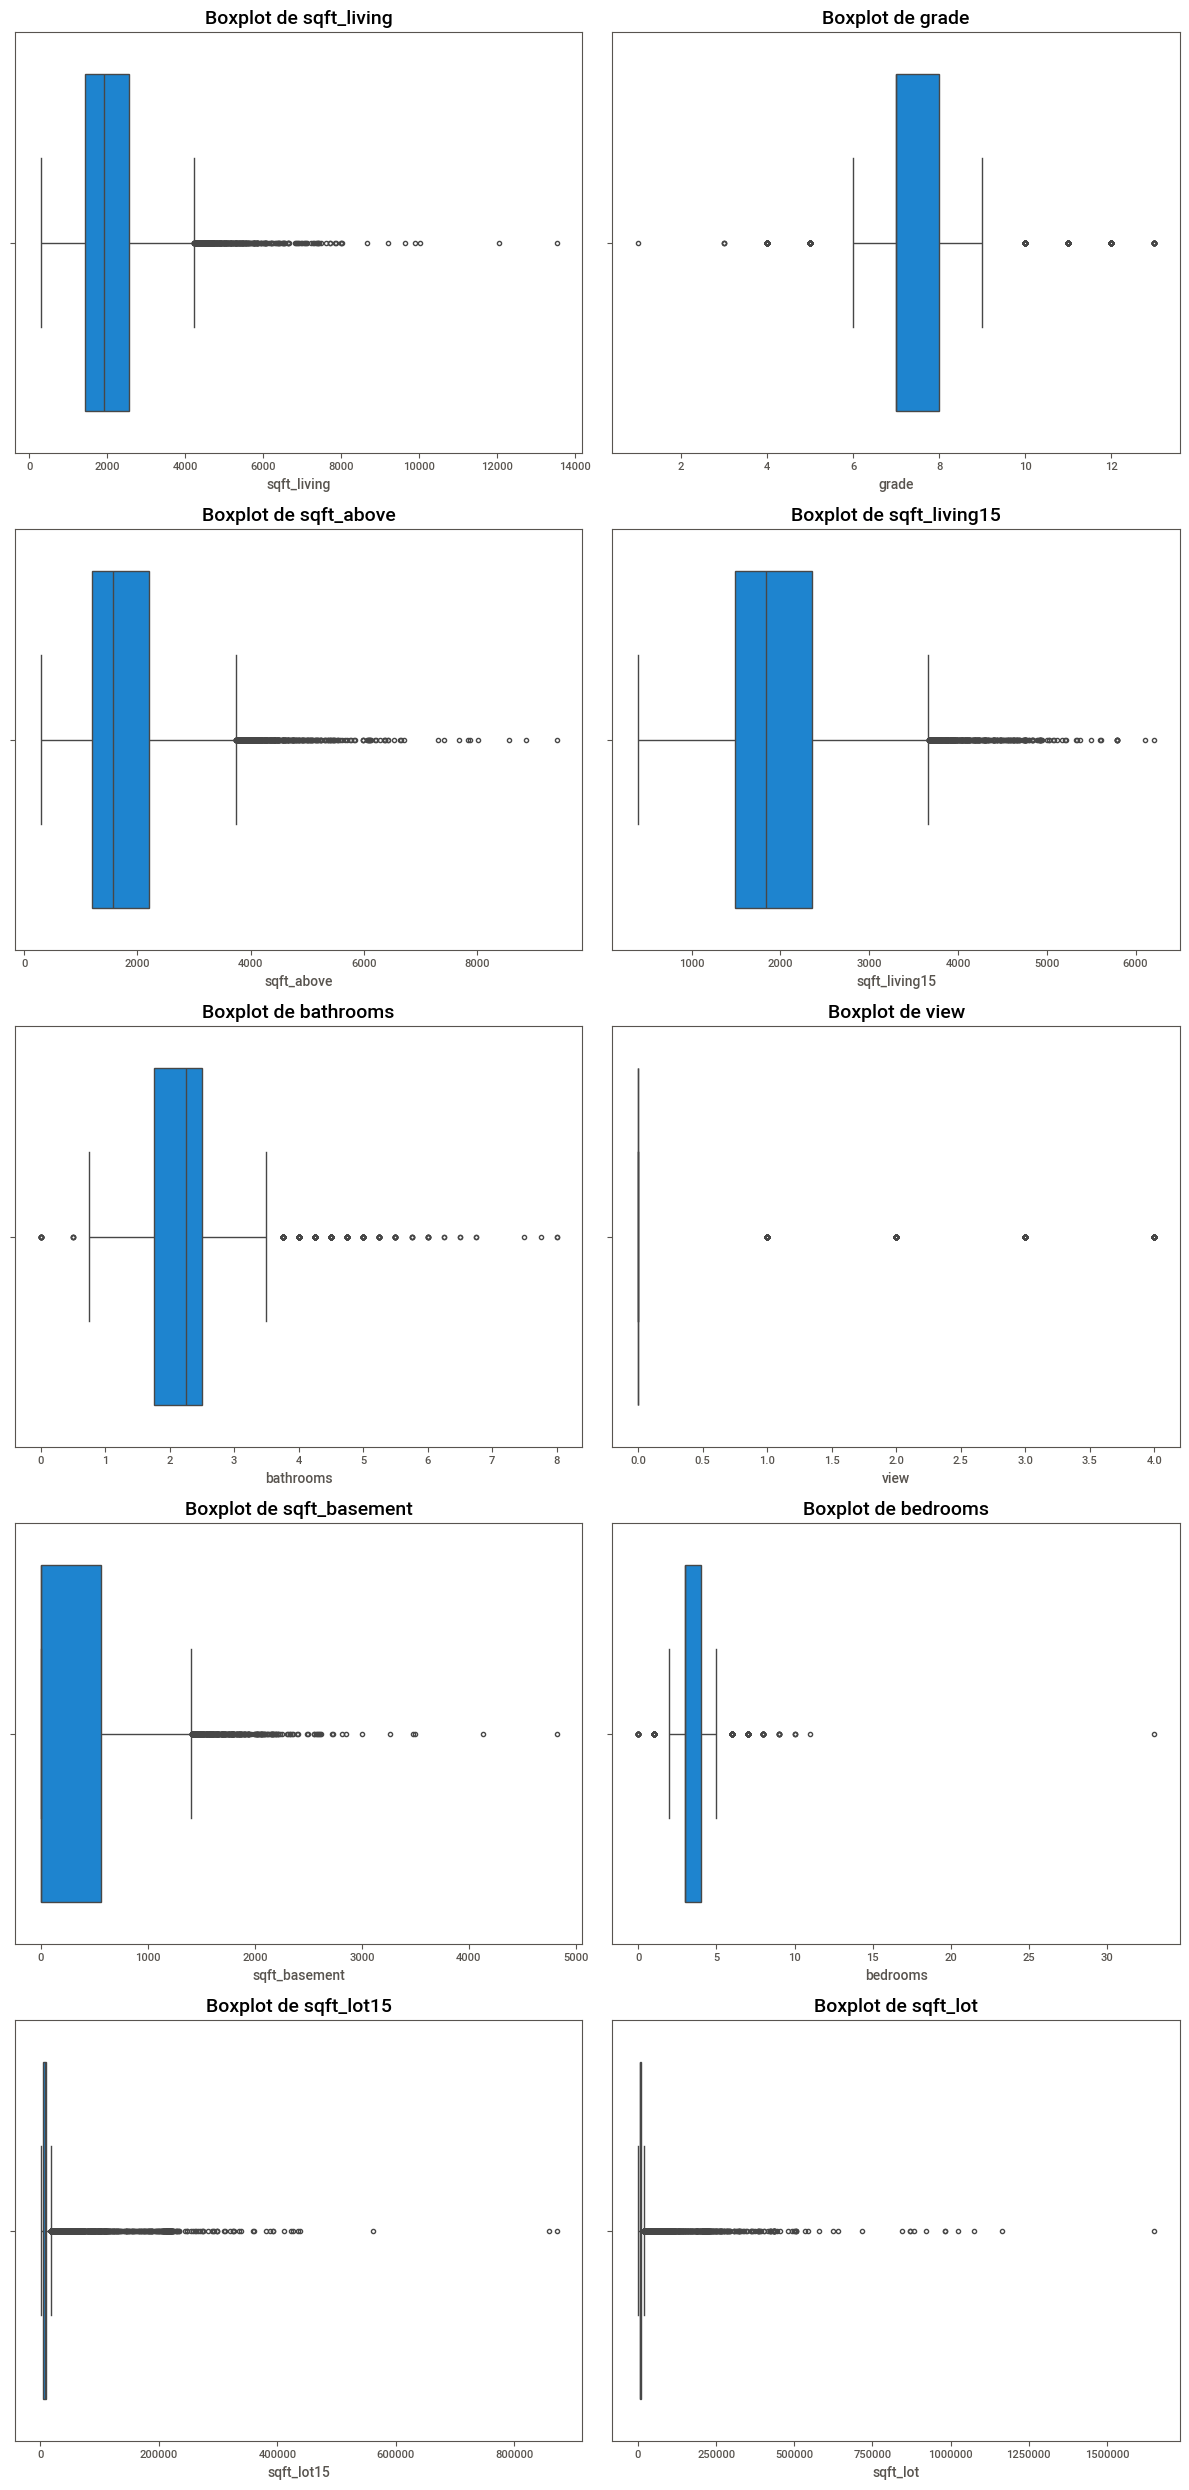

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que tu DataFrame se llama 'df_clean'
# Define una lista de las columnas numéricas que quieres graficar
columnas_a_graficar = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'bedrooms','sqft_lot15','sqft_lot']

# --- Crear la Figura y los Ejes ---
# Determina la cantidad de filas y columnas para el sub-gráfico
num_cols = 2 # Por ejemplo, 2 boxplots por fila
num_rows = (len(columnas_a_graficar) + num_cols - 1) // num_cols # Cálculo para filas necesarias

# Crea la figura y el conjunto de sub-gráficos (axes)
fig, axes = plt.subplots(
    num_rows, 
    num_cols, 
    figsize=(12, 5 * num_rows) # Ajusta el tamaño de la figura
)

# Aplanar el array de ejes para iterar fácilmente, 
# incluso si es un solo gráfico (1x1)
axes = axes.flatten() 

# --- Iterar y Graficar ---
for i, col in enumerate(columnas_a_graficar):
    # sns.boxplot(y=df_clean[col], ax=axes[i]) # Para un boxplot vertical
    sns.boxplot(x=df[col], ax=axes[i], orient='h') # Boxplot horizontal (mejor para múltiples)
    axes[i].set_title(f'Boxplot de {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('') # Quita la etiqueta 'y'

# Ocultar los ejes no utilizados si el número de columnas no es par
for j in range(len(columnas_a_graficar), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espaciado entre subgráficos
plt.tight_layout() 
plt.show()


## conclusiones 1.1 EDA 
* existen algunos registros duplicados en el id que se tienen que depurar en la parte subsiguiente de preprocesamiento de datos
* es necesario cambiar el tipo de dato de la columna bathrooms y floors ya que al ser baños y pisos respectivamente, no pueden existir decimales, convertir a tipo int
* depurar los outliers de la columna bedrooms ya que hay algunos registros que presentan hasta 33 dormitorios, lo cual puede sesgar los modelos, es necesario eliminarlos
* depurar los outliers de la columna sqft_lot ya que existen valores muy altos que no permiten conocer bien la distribucion de los datos y generan sesgos
* adicionalmente:
   - Relación no lineal entre algunas variables y precio
   - Posible multicolinealidad entre variables de área
   - sqft_living: Correlación más fuerte con precio (>0.7)
   - grade: segunda relacion más fuerte, aunque no se explica mucho que es esta variable, es importante.


# 1.2 preprocesamiento datos

Miremos cuantos duplicados hay en la columna "id", deberían tener valores unicos

In [3]:
duplicados = df[df.duplicated(subset='id', keep=False)]
print(f"Número de registros duplicados por 'id': {duplicados['id'].nunique()}")

Número de registros duplicados por 'id': 176


Aqui nos dimos cuenta que hay varios registros duplicados, miremos inicialmente cual puede ser el motivo

In [4]:
# genero un array con los ids duplicados
duplicados_ids = df['id'][df['id'].duplicated()].unique()

# quiero ver un ejemplo de los duplicados
id_ejemplo = duplicados_ids[3]
df_id = df[df['id'] == id_ejemplo]
df_id

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
345,3969300030,20140723T000000,165000,4,1.0,1000,7134,1.0,0,0,...,6,1000,0,1943,0,98178,47.4897,-122.24,1020,7138
346,3969300030,20141229T000000,239900,4,1.0,1000,7134,1.0,0,0,...,6,1000,0,1943,0,98178,47.4897,-122.24,1020,7138


a priori parece que las columnas que difieren son la fecha y el precio, lo cual sugiere que hay registros en los que se actualizó el precio del inmueble en una fecha posterior, validemos esta hipótesis para todos los registros

In [5]:
diferencias = {}

for _id in duplicados_ids:
    filas = df[df['id'] == _id]
    if len(filas) > 1:
        diff = filas.loc[filas.index[0]] != filas.loc[filas.index[1]]
        cols_diff = diff[diff].index.tolist()
        diferencias[_id] = cols_diff

# Mostrar IDs y columnas distintas
for k, v in list(diferencias.items())[:10]:  # solo los primeros 10 para no saturar
    print(f"ID {k} difiere en: {v}")

ID 6021501535 difiere en: ['date', 'price']
ID 4139480200 difiere en: ['date', 'price']
ID 7520000520 difiere en: ['date', 'price']
ID 3969300030 difiere en: ['date', 'price']
ID 2231500030 difiere en: ['date', 'price']
ID 8820903380 difiere en: ['date', 'price']
ID 726049190 difiere en: ['date', 'price']
ID 8682262400 difiere en: ['date', 'price']
ID 9834200885 difiere en: ['date', 'price']
ID 8062900070 difiere en: ['date', 'price']


Efectivamente, las columnas que hacen que estén duplicados son por fecha y precio, como queremos generar un modelo de precios, eliminaremos los registros viejos y dejaremos los mas recientes

ordenamos entonces el dataframe para dejar los registros más actualizados.



In [53]:
# Ordenar por id y fecha (de más reciente a más antigua)
df_sorted = df.sort_values(['id', 'date'], ascending=[True, False])

# Eliminar duplicados, manteniendo SOLO el registro más reciente
df_clean = df_sorted.drop_duplicates(subset='id', keep='first').copy()

In [54]:
duplicados = df_clean[df_clean.duplicated(subset='id', keep=False)]
print(f"Número de registros duplicados por 'id': {duplicados['id'].nunique()}")

Número de registros duplicados por 'id': 0


seguimos depurando nuestro dataframe con los hallazgos encontrados en el EDA

In [55]:
# convierto a tipo int la columna de bathrooms y floors 
df_clean['bathrooms'] = df_clean['bathrooms'].astype(int)
df_clean['floors'] = df_clean['floors'].astype(int)


In [58]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_clean, title="data_precio_viviendas ")
profile.to_file("data_precio_viviendas.html")


ModuleNotFoundError: No module named 'ydata_profiling'